# SIMULATOR AND SUMMONER STATISTICS

In [1]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Load the minimum required library to run the functions
from Utils_functions import *
from numpy.random import uniform
from numpy import array, int64, where, concatenate, linspace, median, sum, log, zeros, mean, var, min, max
from scipy.integrate import cumulative_trapezoid
from scipy.signal import welch
import matplotlib.pyplot as plt
import torch
import numpy as np


2024-04-27 19:59:07.821810: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 19:59:07.871783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 19:59:07.871863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 19:59:07.873492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 19:59:07.881361: I tensorflow/core/platform/cpu_feature_guar

In [3]:
dt = 1e-6 # The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
DeltaT = 2.5e-5 # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
Sample_frequency = 1/DeltaT # The sampling frequency. This is the number of samples that are recorded per unit time
TotalT = 0.5 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
n_sim = 1000
t_corr = TotalT/50

In [4]:
time_steps_amount = int64(TotalT/dt) # Number of steps
sampled_point_amount = int64(TotalT/DeltaT) # Number of sampled points
sampling_delta_time_steps = int64(DeltaT/dt) # Number of steps between samples
t = linspace(0., TotalT,sampled_point_amount) # Time array

Chose the time characteristics of the input signal (total time, sample rate, numbero of simulations) and transform them into points info

In [5]:
# Limits for the parameters
prior_limits = [[1.5e4, 4e4], 
                [1e4, 140e4], 
                [3e-3, 16e-3], 
                [1.5e-2, 30e-2], 
                [1e-3, 6e-3], 
                [2e-2, 20e-2], 
                [0.5, 6], 
                [5.5, 15.5], 
                [1, 530]]

In [8]:
# TO DO: EASY CALL TO THE SIMULATOR TO COMPILE

In [6]:
# Get the theta values from the prior in the different shapes
theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, n_sim)

In [7]:
%%time
x_trace, f_trace, state = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)

CPU times: user 1min 21s, sys: 368 ms, total: 1min 22s
Wall time: 1min 22s


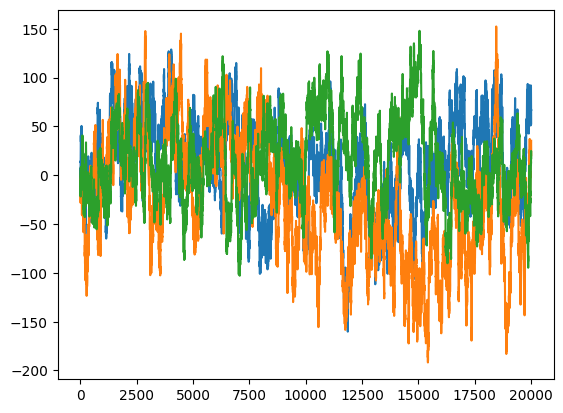

In [9]:
for i in range(3):
    plt.plot(x_trace[i,:])

Simulating the x trajectory and the f trajectory to then obtain the summary statistics, in this case the autocorrellation and the cross correllation in combination with the reduced energy production.

I don't know which formula we can pick to compute the reduce energy production, from autocorrellation, from cross correllation, all together?

ADD: Write a function GET_SUMMONER_STATISTICS() which is a list of functions, each function for a summoner statistic

In [10]:
%%time
list_stat = ["Cxx", "s_redx", "s_redf", "psdx"]
s = get_summary_statistics(list_stat, x_trace, f_trace, theta, DeltaT, 3, t, t_corr)
s.shape

CPU times: user 1min 4s, sys: 3.79 s, total: 1min 8s
Wall time: 1min 8s


torch.Size([1000, 4531])

Maybe we can select different summary statistics and usa some feature selection technique. If we use a lot of summary statistics maybe dimentionality reductions? PCA?
The idea is to use different summary statistics but to then to select the most important features of them deleting the correllations between them.

An example could be the Power spectral density for both x and f.
It can identify if there are any dominant frequencies in your data, or if the power is distributed across a range of frequencies, usefull for oscillatory behaviour

We can use directly the psds as input of the neural network or we can take some statistics about each one, like mean, median, max, min,variance, entropy, frequency of top power. We can think of more statistics

# INFERENCE STATISTICS

In [14]:
from torch import Tensor, Size
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from Utils_functions import prior_func
from numpy import squeeze

In [15]:
# Prior distribution for sbi
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [16]:
# Call infer form sbi
infer = SNPE(prior=prior)
inferece = infer.append_simulations(theta_torch, s)

In [17]:
# Train the model
density_estimator = infer.train()
posterior = infer.build_posterior(density_estimator)

 Neural network successfully converged after 27 epochs.

In [18]:
# Simulate the observation(s)
theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, n_sim=1)
x_trace_true, f_trace_true, state_true = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta_true)

In [20]:
# Sample from the posterior
s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta, DeltaT, 3, t, t_corr)
samples = posterior.sample((1000,), x=s)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

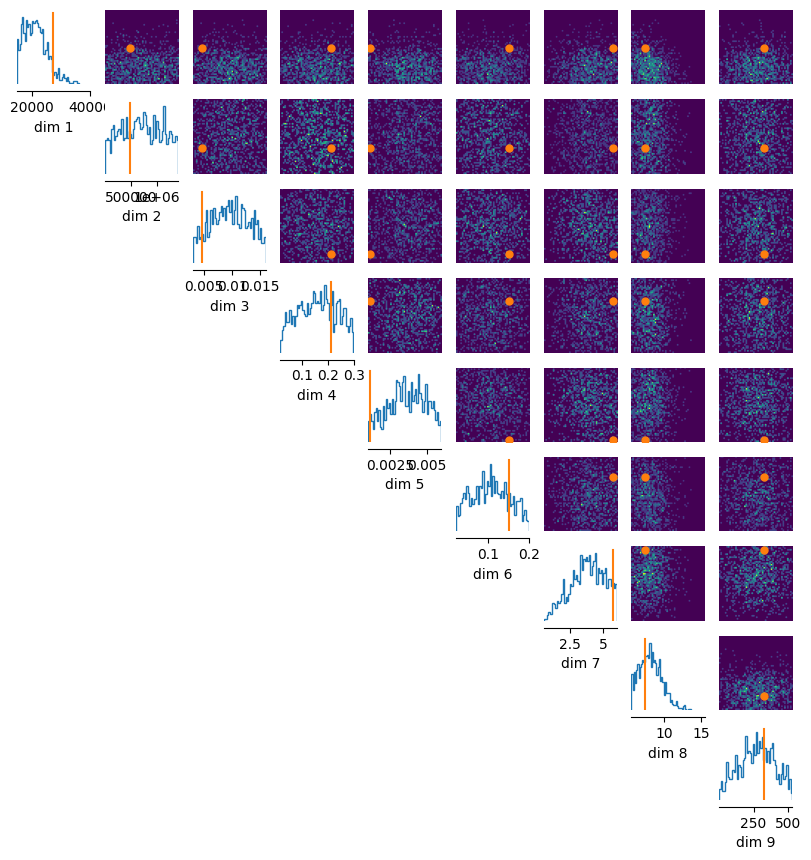

In [21]:
_ = analysis.pairplot(samples, points=theta_torch_true, limits=prior_limits, figsize=(10, 10))